In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import normaltest, jarque_bera, mannwhitneyu

## Data reading and transforming

In [2]:
df = pd.read_csv('athlete_events.csv')
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [3]:
regions = pd.read_csv('noc_regions.csv')
regions.head()

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


Джойним названия регионов к исходному датафрейму с атлетами.

In [4]:
df = df.merge(regions, how='left', on='NOC')
del regions
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN


Сразу хочется поменять названия столбцов: привести все к нижнему регистру.

In [5]:
df.columns = [col_name.lower() for col_name in df.columns]

## Missing values

Посмотрим на наличие пропусков по каждому из столбцов.

In [6]:
df[~df.notes.isnull()].notes

238       United Arab Republic
302       United Arab Republic
303       United Arab Republic
304       United Arab Republic
305       United Arab Republic
                  ...         
270918              Yugoslavia
270946              Yugoslavia
270947              Yugoslavia
270956              Yugoslavia
270957              Yugoslavia
Name: notes, Length: 5039, dtype: object

In [7]:
df.isnull().sum()

id             0
name           0
sex            0
age         9474
height     60171
weight     62875
team           0
noc            0
games          0
year           0
season         0
city           0
sport          0
event          0
medal     231333
region       370
notes     266077
dtype: int64

In [8]:
df[df.region.isnull()].noc.value_counts()

SGP    349
ROT     12
TUV      7
UNK      2
Name: noc, dtype: int64

Много пропусков по:
- `medal`, оно и понятно, у бОльшей части атлетов на конкретном соревновании нет медали, поэтому и пропуски (пропуск = отсутствие медали)
- `notes`, у бОльшей части атлетов на конкретном соревновании есть конкретный регион
- `regions`, не понятно, почему там есть пропуски - обработаем это отдельно
- `age`, `height`, `weight` - тут пропуски понятны, по части отлетов не собирались/не собрались/не сохранились конкретные данные их тела

Посмотрим на NaN'ы по признаку `regions`.

In [9]:
df[df.region.isnull()]

,id,name,sex,age,height,weight,team,noc,games,year,season,city,sport,event,medal,region,notes
578,332,Zarinah Abdullah,F,21.0,NaN,NaN,Singapore,SGP,1992 Summer,1992,Summer,Barcelona,Badminton,Badminton Women's Singles,NaN,NaN,NaN
579,332,Zarinah Abdullah,F,25.0,NaN,NaN,Singapore,SGP,1996 Summer,1996,Summer,Atlanta,Badminton,Badminton Women's Singles,NaN,NaN,NaN
2719,1515,Saiyidah Aisyah Mohamed Rafa'ee,F,28.0,173.0,68.0,Singapore,SGP,2016 Summer,2016,Summer,Rio de Janeiro,Rowing,Rowing Women's Single Sculls,NaN,NaN,NaN
6267,3515,Paulo Amotun Lokoro,M,24.0,170.0,61.0,Refugee Olympic Athletes,ROT,2016 Summer,2016,Summer,Rio de Janeiro,Athletics,"Athletics Men's 1,500 metres",NaN,NaN,Refugee Olympic Team
7659,4264,Ang Peng Siong,M,21.0,180.0,75.0,Singapore,SGP,1984 Summer,1984,Summer,Los Angeles,Swimming,Swimming Men's 100 metres Freestyle,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268752,134454,Zhang Guirong,F,26.0,182.0,95.0,Singapore,SGP,2004 Summer,2004,Summer,Athina,Athletics,Athletics Women's Shot Put,NaN,NaN,NaN
268753,134454,Zhang Guirong,F,30.0,182.0,95.0,Singapore,SGP,2008 Summer,2008,Summer,Beijing,Athletics,Athletics Women's Shot Put,NaN,NaN,NaN
268993,134587,Zhang Xueling,F,21.0,163.0,53.0,Singapore,SGP,2004 Summer,2004,Summer,Athina,Table Tennis,Table Tennis Women's Singles,NaN,NaN,NaN
268994,134587,Zhang Xueling,F,21.0,163.0,53.0,Singapore-1,SGP,2004 Summer,2004,Summer,Athina,Table Tennis,Table Tennis Women's Doubles,NaN,NaN,NaN


In [10]:
# SGP - Singapore
# ROT - Refugee Olympic Athletes
# TUV - Tuvalu
# UNK - unknown (?!)
df[df.region.isnull()].noc.value_counts()

SGP    349
ROT     12
TUV      7
UNK      2
Name: noc, dtype: int64

In [11]:
df[df.noc == 'UNK']

,id,name,sex,age,height,weight,team,noc,games,year,season,city,sport,event,medal,region,notes
61080,31292,Fritz Eccard,M,NaN,NaN,NaN,Unknown,UNK,1912 Summer,1912,Summer,Stockholm,Art Competitions,Art Competitions Mixed Architecture,NaN,NaN,Unknown
130721,65813,A. Laffen,M,NaN,NaN,NaN,Unknown,UNK,1912 Summer,1912,Summer,Stockholm,Art Competitions,Art Competitions Mixed Architecture,NaN,NaN,Unknown


Видим, что большинство пропусков по региону - это либо:
- атлеты региона Сингапур/Тувалу, 
- Олимпийские спортсмены-беженцы (ROT) - люди, которые были вынуждены бежать из родных стран по причине военных конфликтов/бедствий (источник: https://www.rescue.org/article/why-there-refugee-olympic-team) 
- нет информации об атлете совсем, кроме ФИО и пола: таких строк всего две - два отлета, выступавших в 1912 году на летних Олимпийских играх

Функции для дальнейшей отрисовки графиков.

In [12]:
def draw_one_plot(X, Y, xlabel, ylabel, title):
    plt.figure(figsize=(13, 6))
    plt.plot(X, Y)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=18)
    plt.grid()
    plt.show();
    
def draw_two_plots(df, feature, slice_1, slice_2, label_1, label_2, xlabel, ylabel, title):
    plt.figure(figsize=(13, 6))
    plt.plot(*df[df[feature] == slice_1].drop(columns=[feature]).values.T, label=label_1)
    plt.plot(*df[df[feature] == slice_2].drop(columns=[feature]).values.T, label=label_2)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=18)
    plt.legend()
    plt.grid()
    plt.show();

## Missing values of age, height and weight

Посмотрим поподробнее на NaN'ы по признакам `age`, `height`, `weight`: выдвинем гипотезу, что зависимость количества суммарного количества пропусков по этим признакам на конкретной олимпиаде уменьшалась с течением времени. Другими словами, гипотеза состоит в том, что с течением времени пропусков о показателях тел атлетов становилось все меньше и сохранялось все больше информации.

Заметим, что строки не уникальны в смысле айди атлета - один отлет может участвовать сразу в нескольких номинациях на одной олимпиаде. Это учтем ниже, группируя по `id` атлета и считая количество уникальных значений (`nunique`).

In [13]:
# отбрасываем признаки, по которым не хотим учитывать пропуски и считаем долю атлетов по которым нет 
# информации о хотя-бы одном показателе тела в общем числе отлетов, в разрезе годов
tmp = df[
    df.drop(columns=['medal', 'region', 'notes']).isnull().any(axis=1)
][['id', 'year']].groupby('year').nunique().reset_index()
tmp['id'] = tmp['id'] / df[['id', 'year']].groupby('year').nunique().reset_index()['id']
tmp.head()

,year,id
0,1896,0.937500
1,1900,0.972222
2,1904,0.920000
3,1906,0.908442
4,1908,0.907609


Построим график числа количества атлетов с недостающей информации в зависимости от года олимпиады. 

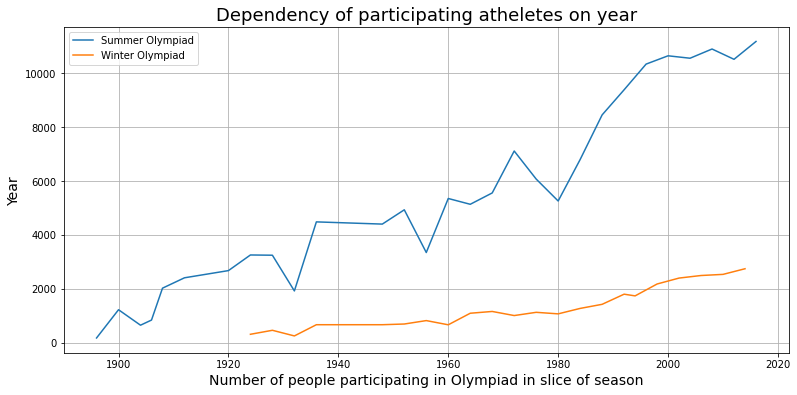

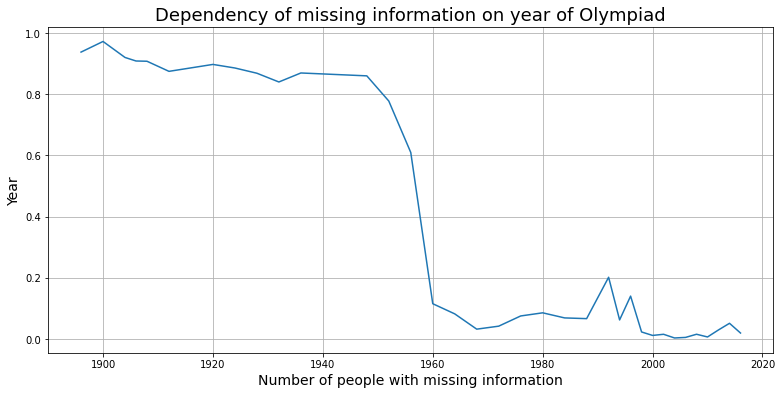

In [14]:
draw_two_plots(df[['season', 'id', 'year']].groupby(['season', 'year']).nunique().reset_index(), 
              feature='season',
              slice_1='Summer',
              slice_2='Winter',
              label_1='Summer Olympiad',
              label_2='Winter Olympiad', 
              xlabel='Number of people participating in Olympiad in slice of season', 
              ylabel='Year', 
              title='Dependency of participating atheletes on year'
)
draw_one_plot(*tmp.values.T, 
              xlabel='Number of people with missing information', 
              ylabel='Year', 
              title='Dependency of missing information on year of Olympiad'
)

Как видно, до середины 20-го века, ситуация совсем плачевная - доля атлетов с пропусками по хотя-бы одному показателю тела более 0.8. Ситуация изменилась кардинально в 1960 году - видимо, когда большинство стран мира восстановилось в экономическом плане после второй мировой войны. После же 1960 года ситуация совсем другая - доля пропусков не более 0.2.

Также, заметно, что зимние олимпийские игры появлись почти на 30 лет позже летних, и до сих пор, остаются менее популярными (популярность в смысле количества атлетов), чем летние олимпийские игры.

Таким образом, гипотеза о том, что с течением времени пропусков становилось все меньше, подтверждается.

Также, интересно - проводились ли олимпийские игры в период второй мировой войны (+- пару лет)?

In [15]:
np.sort(df.year.unique())

array([1896, 1900, 1904, 1906, 1908, 1912, 1920, 1924, 1928, 1932, 1936,
       1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988,
       1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012,
       2014, 2016])

Ответ - нет, с 1936 по 1948 год олимпийские игры не проводились.

## Difference between summer and winter Olympiads

In [16]:
df[['year', 'season']].groupby('year').agg(lambda x: list(set(x)))

,season
year,
1896,[Summer]
1900,[Summer]
1904,[Summer]
1906,[Summer]
1908,[Summer]
1912,[Summer]
1920,[Summer]
1924,"[Summer, Winter]"
1928,"[Summer, Winter]"


Видно, что зимние олимпийские игры появились только в 1924 году и далее, до 1994, и зимние и летние олимпийские игры проводились в один год, а начиная с 1994 года пошло разделение на зимние и летние олимпийские игры: они начали проводиться последовательно, изолированно с промежутком в два года.

## Male atheletes and female athletes

Теперь перейдем непосредственно к атлетам. Посмотрим когда появлись первые атлеты-мужчины и когда появились первые атлеты-женщины.

In [17]:
df[['sex', 'year']].groupby('sex').min().reset_index()

,sex,year
0,F,1900
1,M,1896


Как видно, первые женщины-атлеты появились на 4 года раньше первых атлетов-мужчин.

Теперь посмотрим на распределение количества уникальных мужчин и женщин -атлетов на всех олимпийских играх.

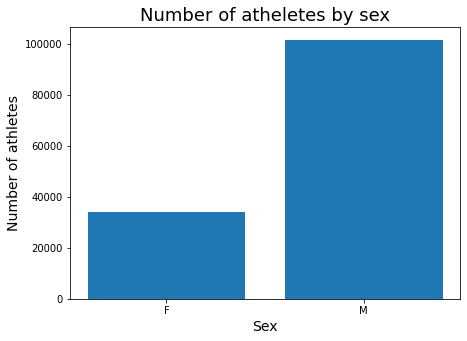

In [18]:
plt.figure(figsize=(7, 5))
plt.bar(*df[['sex', 'id']].groupby(['sex']).nunique().reset_index().values.T)
plt.title('Number of atheletes by sex', fontsize=18)
plt.xlabel('Sex', fontsize=14)
plt.ylabel('Number of athletes', fontsize=14)
plt.show()

Как видно: мужчин почти в три раза больше. Сформулируем гипотезу: в последние 30-40 лет наблюдался резкий рост количества женщин-атлетов на олимпийских играх в связи с либерализацией прав женщин и т.д.

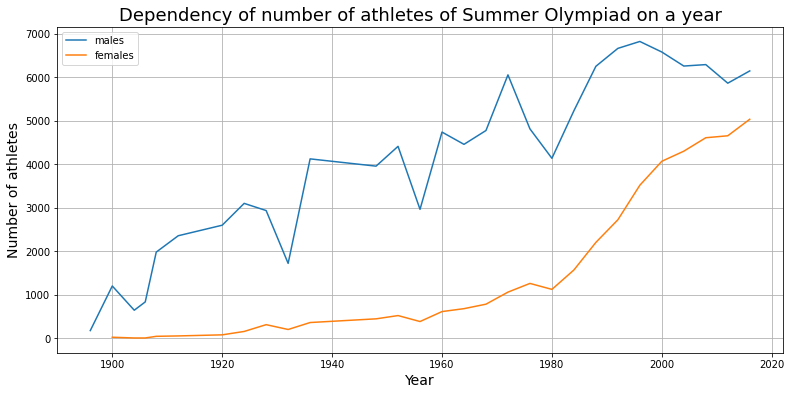

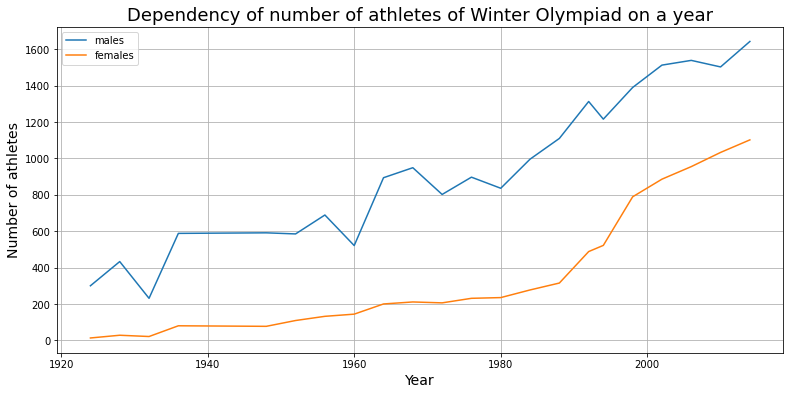

In [19]:
tmp = df[['season', 'year', 'sex', 'id']].groupby(['season', 'year', 'sex']).nunique().reset_index()
draw_two_plots(
    df=tmp[tmp.season == 'Summer'].drop(columns=['season']), 
    feature='sex', 
    slice_1='M', 
    slice_2='F', 
    label_1='males', 
    label_2='females', 
    xlabel='Year', 
    ylabel='Number of athletes', 
    title='Dependency of number of athletes of Summer Olympiad on a year'
)
draw_two_plots(
    df=tmp[tmp.season == 'Winter'].drop(columns=['season']), 
    feature='sex', 
    slice_1='M', 
    slice_2='F', 
    label_1='males', 
    label_2='females', 
    xlabel='Year', 
    ylabel='Number of athletes', 
    title='Dependency of number of athletes of Winter Olympiad on a year'
)

Гипотеза подтверждается: виден заметный рост числа женщин-атлетов, начиная с 1980 года, как на летних, так и на зимних олимпийских играх. 

Как на летних, так и на зимних олимпийских играх, если у мужчин временной ряд количества атлетов более напоминает линейный тренд, то у женщин тренд более напоминает параболический/экспоненциальный.

В современном же мире, что на летних, что на зимних олимпийских играх, до сих пор, мужчин-атлетов больше на примерно тысячу человек, чем мужчин-женщин.

## Возраст, вес и рост олимпийских атлетов

Теперь перейдем к показателям тел атлетов.

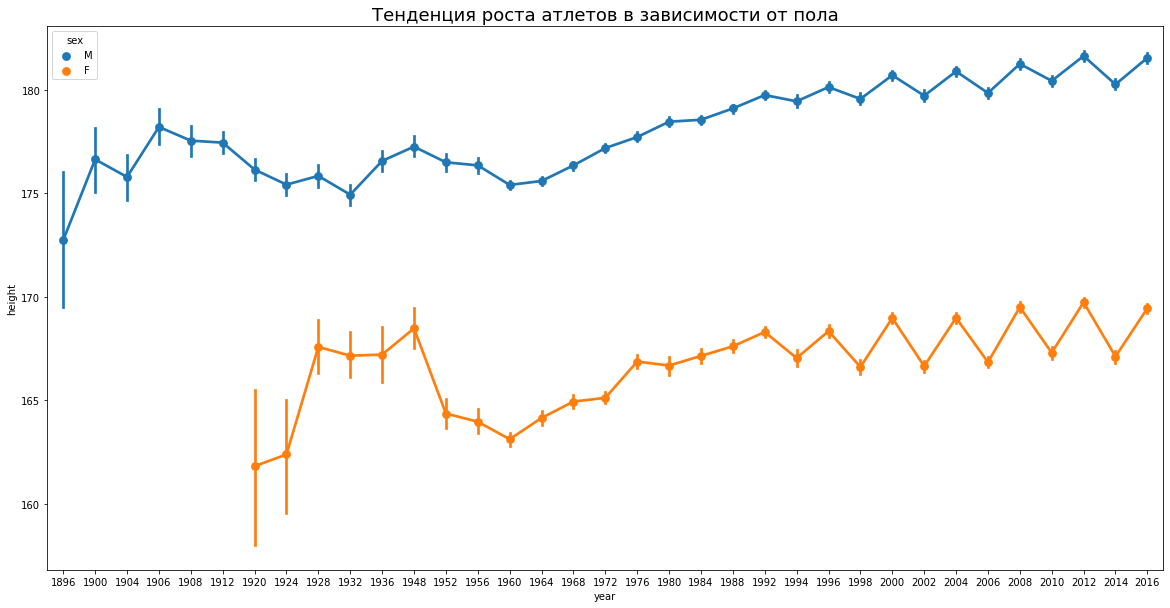

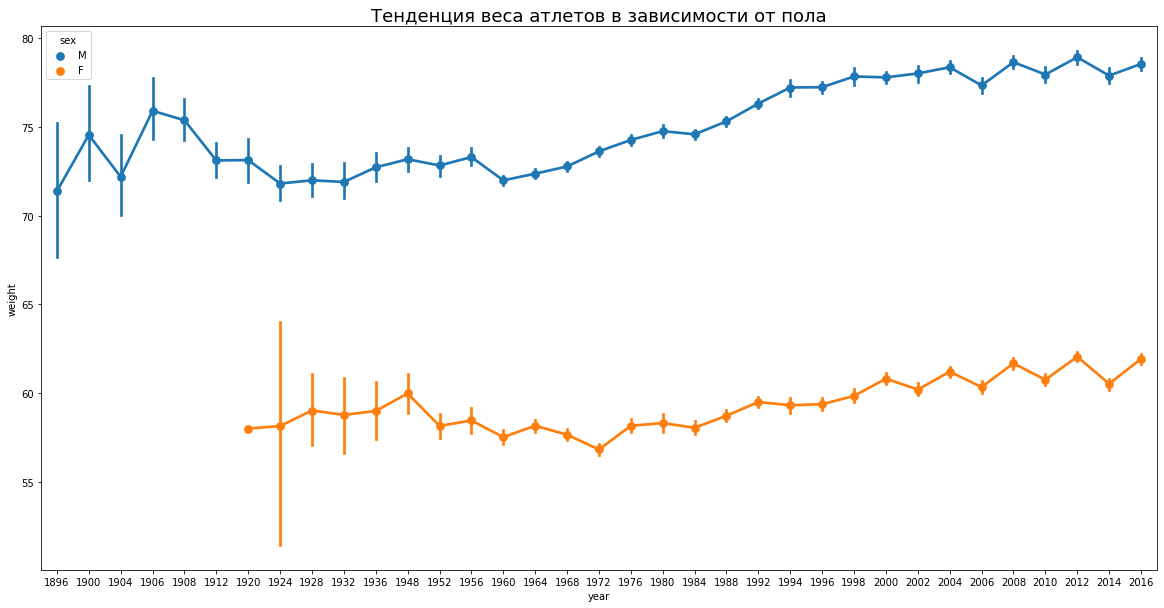

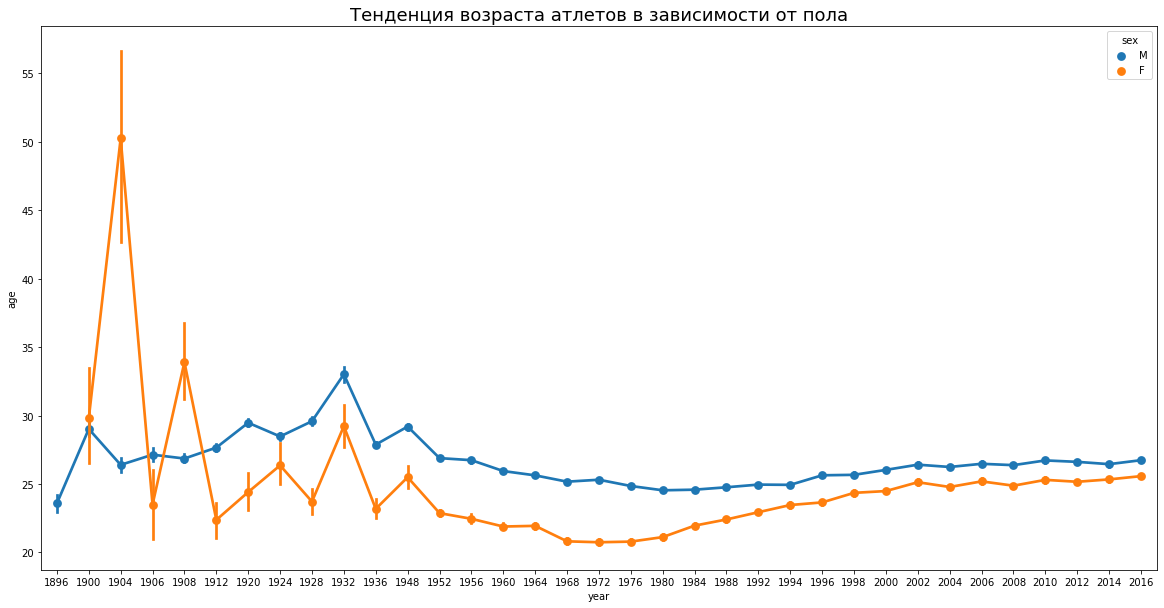

In [20]:
plt.figure(figsize=(20, 10))
sns.pointplot(x='year', y='height', data=df, hue='sex')
plt.title('Тенденция роста атлетов в зависимости от пола', size=18)
plt.figure(figsize=(20, 10))
sns.pointplot(x='year', y='weight', data=df, hue='sex')
plt.title('Тенденция веса атлетов в зависимости от пола', size=18)
plt.figure(figsize=(20, 10))
sns.pointplot(x='year', y='age', data=df, hue='sex')
plt.title('Тенденция возраста атлетов в зависимости от пола', size=18)
plt.show();

Видна тенденция к увеличению с течением времени веса и роста атлетов, что касается возраста - видна "асимптота", как для мужчин, так и женщин, в 26-27 лет.

Очень интересно, что в 1904 году был аномально высокий возраст атлетов-женщин. Посмотрим поподробнее.

In [21]:
df[(df.year == 1904) & (df.sex == 'F')][['sport', 'name', 'age']].groupby(['sport', 'name']).min()

age
sport   name                                         
Archery Emily Woodruff (Smiley-)                 58.0
        Emma C. Cooke                            55.0
        Leonora Josephine "Leonie" Taylor         NaN
        Lida Peyton "Eliza" Pollock (McMillen-)  63.0
        Mabel Caroline Taylor (-Brummel)         24.0
        Matilda "Lida" Howell (Scott-)           44.0

Как видно, такое произошло из за того, что женщин было всего 6, причем по одной из них нет информации о возрасте, также, спортом является стрельба из лука (довольно "немолодой" вид спорта).

## Age, height and weight distribution of different slices and stattests

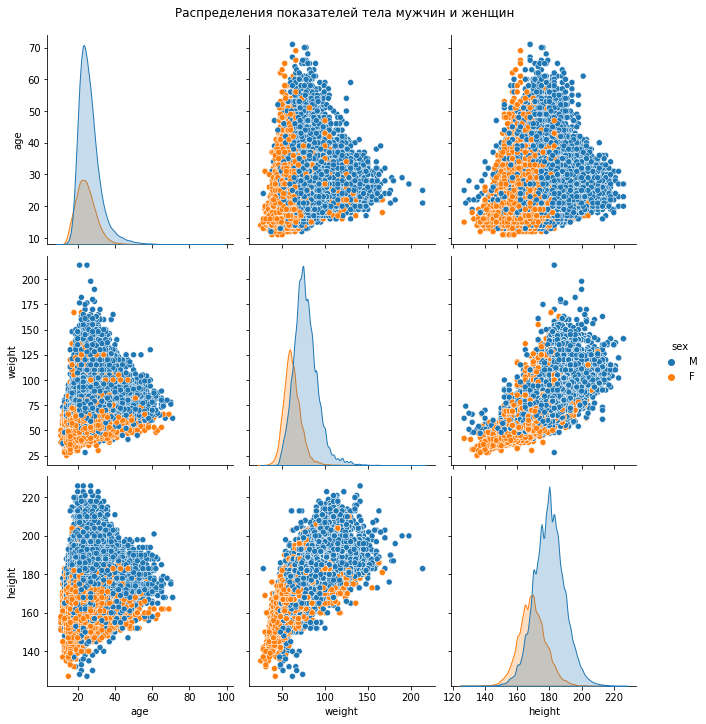

In [22]:
tmp = df[["id", "age", "weight", "height", "sex"]].drop_duplicates().drop(columns='id')
g = sns.pairplot(tmp, hue="sex")
g.fig.suptitle("Распределения показателей тела мужчин и женщин", y=1.02)
g.fig.set_size_inches(10, 10);

Как видно, распределения роста, веса для мужчин и женщин сильно отличаются - мужские распределения смещены "вправо", а распределения возраста примерно похожи.

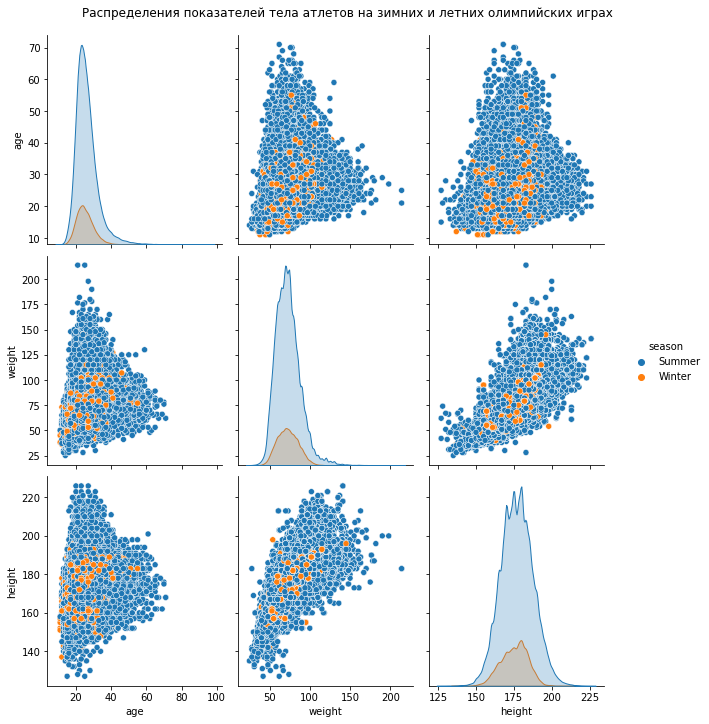

In [23]:
tmp = df[['season', "id", "age", "weight", "height", "sex"]].drop_duplicates().drop(columns=['id', 'sex'])
g = sns.pairplot(tmp, hue="season")
g.fig.suptitle("Распределения показателей тела атлетов на зимних и летних олимпийских играх", y=1.02)
g.fig.set_size_inches(10, 10);

Как видно, что на летних, что на зимних олимпийских играх распределения возраста, веса и роста графически похожи на нормальные, средний рост примерно равен 175см, средний вес примерно равен 80кг, а средний возраст примерно равен 25 годам.

Проверим гипотезы о нормальности различных распределений показателей тела атлетов в разных срезах.

In [24]:
def test_normality(data, feature_name, alpha=0.05):
    data.dropna(inplace=True)
    p1 = normaltest(data)[0]
    p2 = jarque_bera(data)[0]
    p3 = normaltest(np.log1p(data))[0]
    p4 = jarque_bera(np.log1p(data))[0]
    if p1 < alpha:
        print(f'By normaltest {feature_name.upper()} has normal distribution')
    else:
        print(f'By normaltest {feature_name.upper()} has NOT normal distribution')
    if p2 < alpha:
        print(f'By Jarque-Beta test {feature_name.upper()} has normal distribution')
    else:
        print(f'By Jarque-Beta test {feature_name.upper()} has NOT normal distribution')
    if p3 < alpha:
        print(f'By normaltest {feature_name.upper()} has log-normal distribution')
    else:
        print(f'By normaltest {feature_name.upper()} has NOT log-normal distribution')
    if p4 < alpha:
        print(f'By Jarque-Beta test {feature_name.upper()} has log-normal distribution')
    else:
        print(f'By Jarque-Beta test {feature_name.upper()} has NOT log-normal distribution')

In [25]:
def test_hypothesis_on_slices(df, feature, stat_test):
    print(f'For MEN feature {feature.upper()}:\n')
    stat_test(df[df.sex == 'M'][feature], feature)
    print()
    print(f'For WOMEN feature {feature.upper()}:\n')
    stat_test(df[df.sex == 'F'][feature], feature)
    print()
    print(f'For MEN on SUMMER Olympiad feature {feature.upper()}:\n')
    stat_test(df[(df.sex == 'M') & (df.season == 'Summer')][feature], feature)
    print()
    print(f'For MEN on WINTER Olympiad feature {feature.upper()}:\n')
    stat_test(df[(df.sex == 'M') & (df.season == 'Winter')][feature], feature)
    print()
    print(f'For WOMEN on SUMMER Olympiad feature {feature.upper()}:\n')
    stat_test(df[(df.sex == 'F') & (df.season == 'Summer')][feature], feature)
    print()
    print(f'For WOMEN on WINTER Olympiad feature {feature.upper()}:\n')
    stat_test(df[(df.sex == 'F') & (df.season == 'Winter')][feature], feature)
    print()

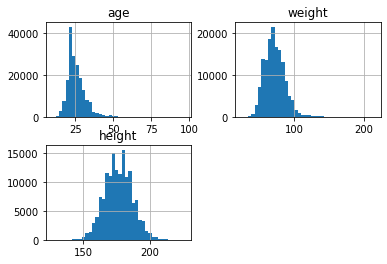

In [26]:
tmp = df[['season', "id", "age", "weight", "height", "sex"]].drop_duplicates()
tmp[['age', 'weight', 'height']].hist(bins=40);

In [27]:
tmp = df[['season', "id", "age", "weight", "height", "sex"]].drop_duplicates()
for feature in ['age', 'height', 'weight']:
    print('========' * 5)
    print(f'FEATURE {feature}')
    print('')
    test_hypothesis_on_slices(tmp, 'age', test_normality)

FEATURE age

For MEN feature AGE:

By normaltest AGE has NOT normal distribution
By Jarque-Beta test AGE has NOT normal distribution
By normaltest AGE has NOT log-normal distribution
By Jarque-Beta test AGE has NOT log-normal distribution

For WOMEN feature AGE:

By normaltest AGE has NOT normal distribution
By Jarque-Beta test AGE has NOT normal distribution
By normaltest AGE has NOT log-normal distribution
By Jarque-Beta test AGE has NOT log-normal distribution

For MEN on SUMMER Olympiad feature AGE:

By normaltest AGE has NOT normal distribution
By Jarque-Beta test AGE has NOT normal distribution
By normaltest AGE has NOT log-normal distribution
By Jarque-Beta test AGE has NOT log-normal distribution

For MEN on WINTER Olympiad feature AGE:

By normaltest AGE has NOT normal distribution
By Jarque-Beta test AGE has NOT normal distribution
By normaltest AGE has NOT log-normal distribution
By Jarque-Beta test AGE has NOT log-normal distribution

For WOMEN on SUMMER Olympiad feature AG

/usr/local/lib/python3.9/site-packages/pandas/core/series.py:5258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


By normaltest AGE has NOT normal distribution
By Jarque-Beta test AGE has NOT normal distribution
By normaltest AGE has NOT log-normal distribution
By Jarque-Beta test AGE has NOT log-normal distribution

For WOMEN on WINTER Olympiad feature AGE:

By normaltest AGE has NOT normal distribution
By Jarque-Beta test AGE has NOT normal distribution
By normaltest AGE has NOT log-normal distribution
By Jarque-Beta test AGE has NOT log-normal distribution

FEATURE height

For MEN feature AGE:

By normaltest AGE has NOT normal distribution
By Jarque-Beta test AGE has NOT normal distribution
By normaltest AGE has NOT log-normal distribution
By Jarque-Beta test AGE has NOT log-normal distribution

For WOMEN feature AGE:

By normaltest AGE has NOT normal distribution
By Jarque-Beta test AGE has NOT normal distribution
By normaltest AGE has NOT log-normal distribution
By Jarque-Beta test AGE has NOT log-normal distribution

For MEN on SUMMER Olympiad feature AGE:

By normaltest AGE has NOT normal d

Несмотря на то, что графически распределения на различных срезах похожи на нормальные, ни один статтест не показал нормальности на любом из распределений, поэтому считаем, что распределения рассмотренных числовых признаков не имеют нормального распределения.

Поскольку все тесты на нормальность показали, что возраст/рост/вес распределены НЕнормально, то далее будем использовать непараметрический тест Манна-Уитни для сравнения двух независимых выборок по уровню какого-либо признака, измеренного количественно.

In [28]:
def mannwhitneyu_test(df, feature, feature_slice, alpha=0.05):
    slice_1, slice_2 = df[feature_slice].unique().tolist()
    p = mannwhitneyu(
        df[df[feature_slice] == slice_1][feature].dropna(), 
        df[df[feature_slice] == slice_2][feature].dropna()
    )[1]
    if p < alpha:
        print('There is a statistically significant difference in '
              f'the {feature} of {feature_slice} {slice_1} and {slice_2}')
    else:
        print('There is no statistically significant difference in '
              f'the {feature} of {feature_slice} {slice_1} and {slice_2}')

In [29]:
for feature in ['age', 'height', 'weight']:
    print('========' * 5)
    print(f'FEATURE {feature}')
    for feature_slice in ['season', 'sex']:
        mannwhitneyu_test(tmp, feature, feature_slice)
        print()
        
for feature in ['age', 'height', 'weight']:
    print('========' * 5)
    for status in ['F', 'M']:
        print(f'FEATURE {feature} ON sex = {status}')
        mannwhitneyu_test(tmp[tmp.sex == status], feature, 'season')
        print()
    
    for status in ['Winter', 'Summer']:
        print(f'FEATURE {feature} ON season = {status}')
        mannwhitneyu_test(tmp[tmp.season == status], feature, 'sex')
        print()

FEATURE age
There is a statistically significant difference in the age of season Summer and Winter

There is a statistically significant difference in the age of sex M and F

FEATURE height
There is a statistically significant difference in the height of season Summer and Winter

There is a statistically significant difference in the height of sex M and F

FEATURE weight
There is a statistically significant difference in the weight of season Summer and Winter

There is a statistically significant difference in the weight of sex M and F

FEATURE age ON sex = F
There is a statistically significant difference in the age of season Winter and Summer

FEATURE age ON sex = M
There is a statistically significant difference in the age of season Summer and Winter

FEATURE age ON season = Winter
There is a statistically significant difference in the age of sex F and M

FEATURE age ON season = Summer
There is a statistically significant difference in the age of sex M and F

FEATURE height ON sex =

На всевозможных срезах (мужчины/женщины, зимние/летние олимпийские игры и их комбинациях) критерий Манна-Уитни показывает статистическую значимость различий соответсвующих распределений числового признака (возраст/вес/рост).

Убедимся в этом глазами, посмотрев на графики.

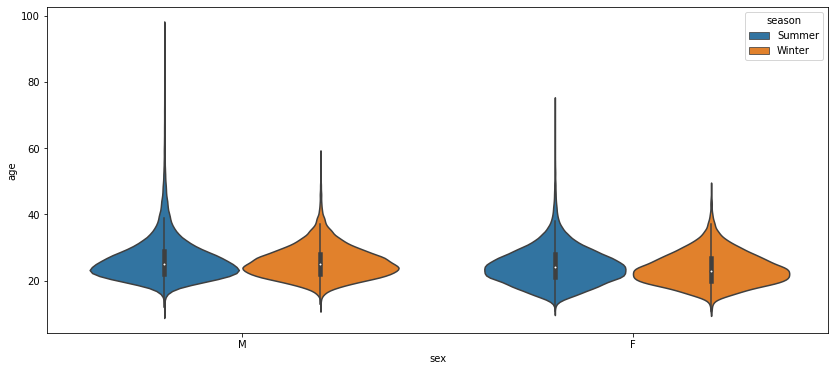

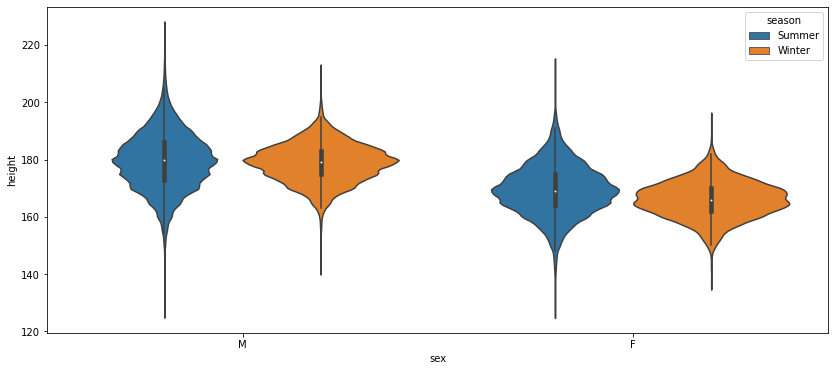

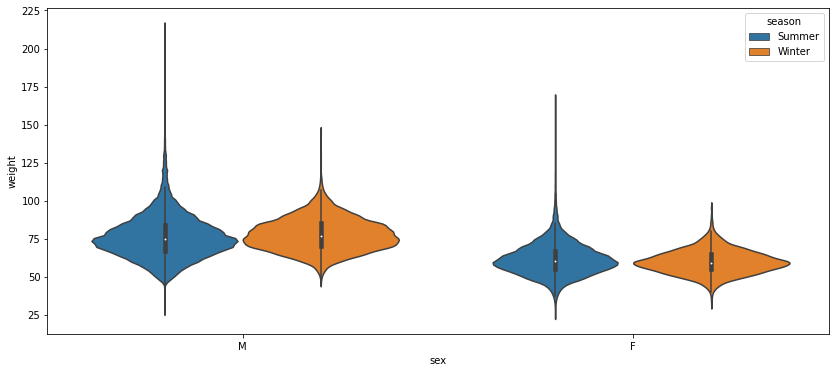

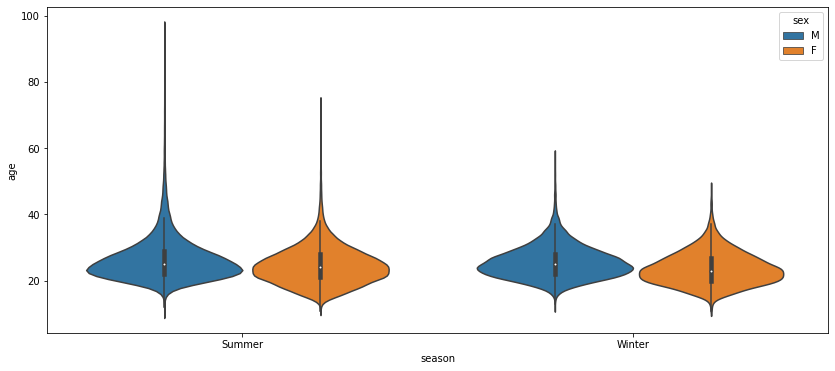

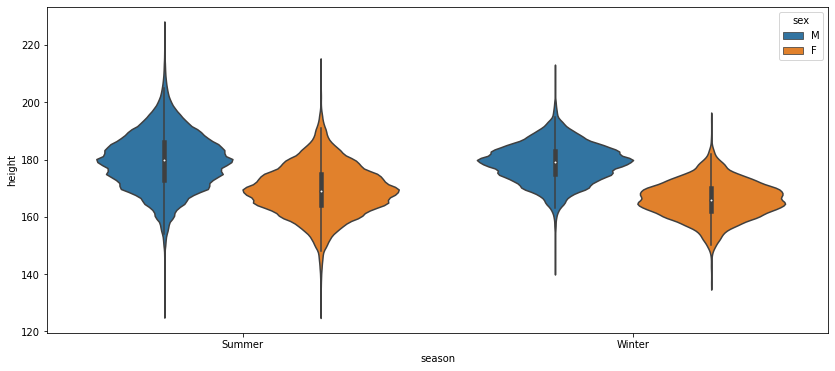

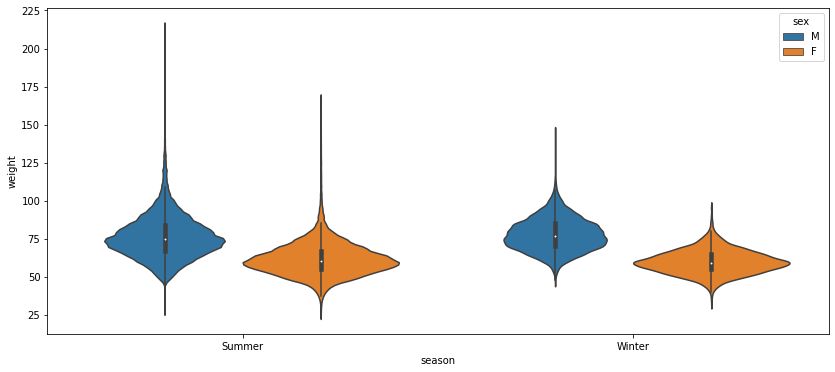

In [30]:
plt.figure(figsize=(14, 6))
sns.violinplot(
    y='age',
    x='sex',
    data=df[['id', 'age', 'sex', 'season']].drop_duplicates(),
    hue='season'
);
plt.figure(figsize=(14, 6))
sns.violinplot(
    y='height',
    x='sex',
    data=df[['id', 'height', 'sex', 'season']].drop_duplicates(),
    hue='season'
);
plt.figure(figsize=(14, 6))
sns.violinplot(
    y='weight',
    x='sex',
    data=df[['id', 'weight', 'sex', 'season']].drop_duplicates(),
    hue='season'
);

plt.figure(figsize=(14, 6))
sns.violinplot(
    y='age',
    x='season',
    data=df[['id', 'age', 'sex', 'season']].drop_duplicates(),
    hue='sex'
);
plt.figure(figsize=(14, 6))
sns.violinplot(
    y='height',
    x='season',
    data=df[['id', 'height', 'sex', 'season']].drop_duplicates(),
    hue='sex'
);
plt.figure(figsize=(14, 6))
sns.violinplot(
    y='weight',
    x='season',
    data=df[['id', 'weight', 'sex', 'season']].drop_duplicates(),
    hue='sex'
);

Видно, что распределения так или иначе сильно отличаются: либо "центрами" распределения, либо хвостами, либо несимметричностью.

## Medals of athletes

Посмотрим на тех атлетов, которые заработали больше всего медалей.

In [31]:
tmp = pd.crosstab(df['name'], df['medal'])
tmp['Total'] = tmp.sum(axis=1)
tmp.sort_values(by=['Total'], ascending=False, inplace=True)
tmp = tmp.merge(
    df[['name', 'sport']].groupby('name').agg(lambda x: list(set(x))).reset_index(), 
    how='left', 
    on='name')
tmp.head(10)

,name,Bronze,Gold,Silver,Total,sport
0,"Michael Fred Phelps, II",2,23,3,28,[Swimming]
1,Larysa Semenivna Latynina (Diriy-),4,9,5,18,[Gymnastics]
2,Nikolay Yefimovich Andrianov,3,7,5,15,[Gymnastics]
3,Borys Anfiyanovych Shakhlin,2,7,4,13,[Gymnastics]
4,Takashi Ono,4,5,4,13,"[Judo, Gymnastics]"
5,Ole Einar Bjrndalen,1,8,4,13,"[Biathlon, Cross Country Skiing]"
6,Edoardo Mangiarotti,2,6,5,13,[Fencing]
7,Ryan Steven Lochte,3,6,3,12,[Swimming]
8,Birgit Fischer-Schmidt,0,8,4,12,[Canoeing]
9,Paavo Johannes Nurmi,0,9,3,12,[Athletics]


Как видно, абсолютным лидером по числу золотых медалей и медалей всего является Майкл Фелпс - знаменитый американский пловец. Другие атлеты из топа-10 атлетов по медалям являются гимнастами.

## Medals of countries

Посмотрим на распределение медалей по странам (создадим фиктивную страну - Россия + СССР).

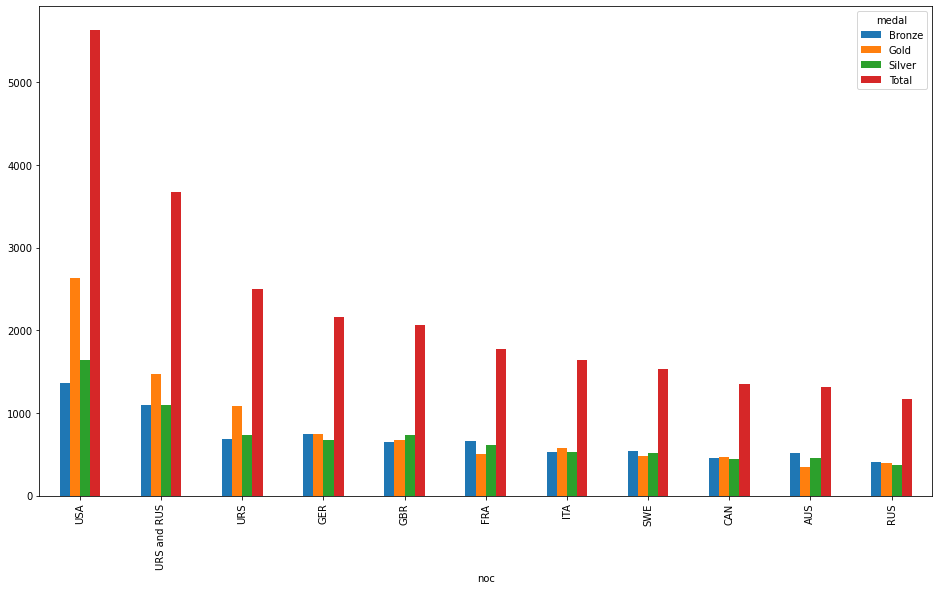

In [32]:
tmp = pd.crosstab(df['noc'], df['medal'])
tmp['Total'] = tmp.sum(axis=1)
tmp.loc['URS and RUS'] = tmp.loc['URS'] + tmp.loc['RUS']
tmp.sort_values(by=['Total'], ascending=False, inplace=True)
tmp[tmp["Total"] >= 100][:11].plot.bar(figsize=(16, 9));

Как видно, абсолютный лидер по числу заработанных медалей -  США, далее идет Советский Союз + Рооссия, а затем Советский Союз. Удивительно, что несмотря на то, что советского союза нет уже 30 лет, он находится в топ-2 (топ-2 потому что по факту страны Россия + СССР нет) по числу заработанных медалей.

## Counties athletes

Посмотрим на топ-10 стран по суммарному количеству участников за все годы.

In [33]:
df[["noc", "id"]].groupby("noc").nunique().sort_values(by="id", ascending=False)[:10]

,id
noc,
USA,9653
GBR,6281
FRA,6170
ITA,4935
GER,4872
CAN,4811
JPN,4067
AUS,3820
SWE,3787


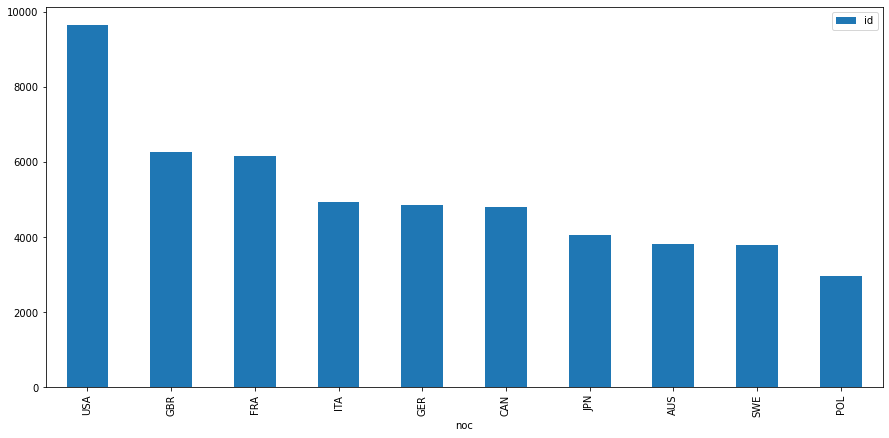

In [34]:
df[["noc", "id"]].groupby("noc").nunique().sort_values(by="id", ascending=False)[:10].plot.bar(figsize=(15, 7));

Опять же, абсолютный лидер - США, однако, в данном топе нет ни России, ни СССР. 

Кажется, что это говорит о том, что спорстмены из России и СССР более "талантливые", поскольку имеют больше медалей на меньшее количество человек. Проверим это, посмотрев для каждой страны на долю медалистов в общем количестве участников олимпиады.

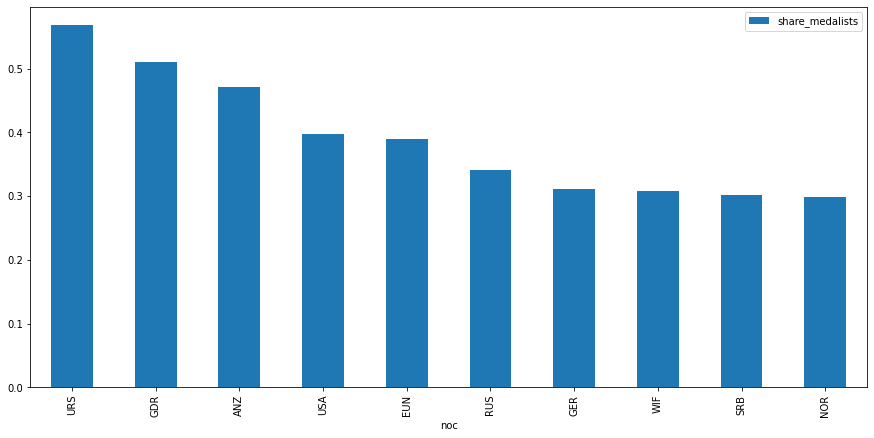

In [35]:
tmp = df[~df.medal.isnull()][["noc", "id"]].groupby("noc").nunique().reset_index()
tmp = tmp.merge(df[["noc", "id"]].groupby("noc").nunique().reset_index(), on='noc', how='left')
tmp.columns = ['noc', 'n_medalists', 'n_athletes']
tmp['share_medalists'] = tmp['n_medalists'] / tmp['n_athletes']
tmp.sort_values(by='share_medalists', ascending=False, inplace=True)
tmp.index = tmp.noc
tmp[['share_medalists']][:10].plot.bar(figsize=(15, 7));

Гипотеза подтверждается - удивительно, но каждый второй атлет из СССР является медалистом. Далее идет ГДР, Австралия и Новая Зеландия и только потом США.

Отметим, что в России тоже отличные показатели талантливости спортсменов - каждый третий спортсмен является медалистом.

## Cities where were multiple olympiads 

Посмотрим на то, есть ли города, в которых олимпийские игры проходили более одного раза.

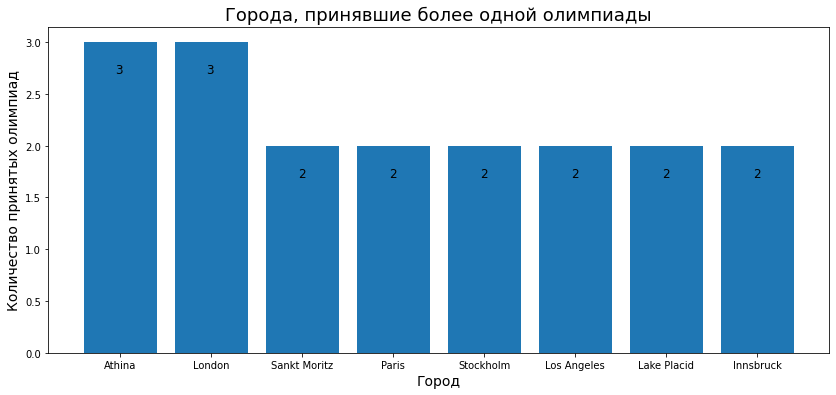

In [36]:
tmp = df[["year", "city"]].groupby("city")["year"].nunique().sort_values(ascending=False)
tmp = tmp[tmp >= 2]
plt.figure(figsize=(14, 6))
plt.bar(tmp.index, tmp)
plt.title('Города, принявшие более одной олимпиады', size=18)
plt.xlabel('Город', size=14)
plt.ylabel('Количество принятых олимпиад', size=14)
for i, v in enumerate(tmp):
    plt.text(i - 0.05 , v - 0.3 , str(v), size = 12)

Интересные результаты: Лондон и Афины целых три раза принимали олимпийские игры.

## Types of sports

Посмотрим на "старейшие" и "новейшие" виды спорта.

In [37]:
tmp = df[['sport', 'year']].groupby('sport').min().sort_values(by=['year'])
tmp[tmp.year == tmp.year.min()].index.tolist()

['Wrestling',
 'Weightlifting',
 'Athletics',
 'Gymnastics',
 'Tennis',
 'Swimming',
 'Shooting',
 'Fencing',
 'Cycling']

Старейшие виды спорта - реслинг, тяжелая атлетика, легкая атлетика, гимнастика, теннис, плавание, стрельба, езда на велосипеде, фехтование.

In [38]:
tmp = df[['sport', 'year']].groupby('sport').min().sort_values(by=['year'])
tmp[tmp.year > 1995]

,year
sport,
Softball,1996
Beach Volleyball,1996
Snowboarding,1998
Taekwondo,2000
Trampolining,2000
Triathlon,2000
Rugby Sevens,2016


Новейшие виды спорта - софтбол, пляжный волейбол, сноубординг, тхеквондо, трамплин, триатлон и регби.

Посмотрим на топ-10 видов спорта, которые наиболее популярны (с точки зрения количества участников).

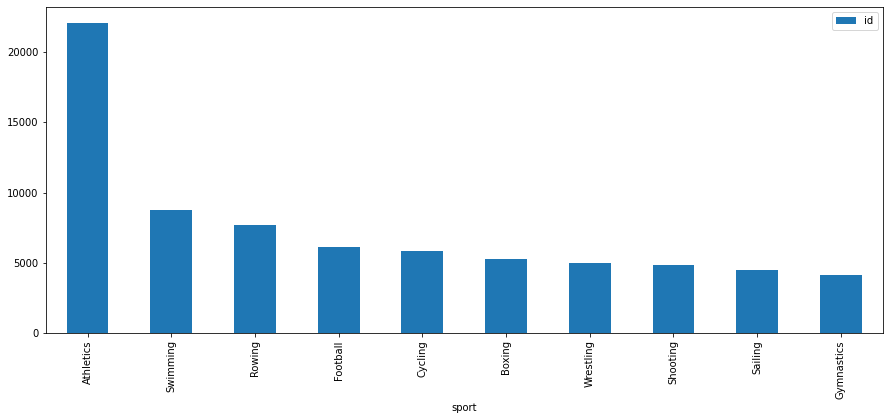

In [39]:
df[['id', 'sport']].groupby('sport').nunique().sort_values(by='id', ascending=False)[:10].plot.bar(figsize=(15, 6));

Удивительно, но наиболее популярные виды спорта, преимущественно, вовсе не командные - это легкая атлетика, плавание, гребля (частично командный), футбол (командный), езда на велосипеде, бокс и др. 

## Conclusions

Таким образом, данный датасет об истории олимпийских игр на протяжении 120 лет имеет очень много интересных закономерностей и фактов.

Особенно удивительным для меня оказались достижения СССР в олимпийских играх - как количество медалей, так и доля медалистов среди всех атлетов.